# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



First we load the data

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

# 1. Define Party Colors (Based on standard Danish political colors)
party_colors = {
    'Socialdemokratiet': '#b31518',       # A (Red)
    'Venstre': '#0f85ca',                 # V (Blue)
    'Moderaterne': '#800080',             # M (Purple)
    'Socialistisk Folkeparti': '#d61a5e', # F (Red/Pink)
    'Danmarksdemokraterne': '#004d99',    # D (Dark Blue)
    'Nye Borgerlige': '#005599',          # D (Similar Dark Blue)
    'Liberal Alliance': '#ef852d',        # I (Orange)
    'Det Konservative Folkeparti': '#00583c', # C (Green)
    'Enhedslisten': '#7e1e36',            # Æ (Red-Green)
    'Radikale Venstre': '#e6007e',        # B (Magenta)
    'Alternativet': '#00ff00',            # Z (Bright Green)
    'Dansk Folkeparti': '#dfba08',        # O (Yellow)
    'Frie Grønne, Danmarks Nye Venstrefløjsparti': '#32cd32', # G (Green)
    'Kristendemokraterne': '#f6b12d',     # K (Orange/Yellow)
    'Løsgænger': '#808080'                # Independents (Grey)
}

try:
    # Loading alldata.xlsx as it contains responses from both stations
    df = pd.read_excel('alldata.xlsx')
    print("Data loaded successfully.")
    print(f"Shape: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("File not found. Please check the path.")

Data loaded successfully.
Shape: (867, 53)


,530,531,533,534,535,537,538,540,541,543,...,9a,9b,10a,10b,11a,11b,12a,12b,storkreds,alder
0,-1,-2,1,-2,2,1,-2,1,1,2,...,2,0,1,-2,-2,1,1,1,Københavns Storkreds,78
1,2,2,-1,-2,-1,-2,1,-2,2,-2,...,-2,0,-1,2,1,-2,0,0,Fyns Storkreds,64
2,2,1,-2,-2,1,-2,1,-1,1,-1,...,-1,-2,0,2,0,-1,1,-2,Bornholms Storkreds,37
3,2,1,-2,-1,1,1,1,1,1,-2,...,-2,2,2,2,2,-1,2,0,Nordjyllands Storkreds,28
4,1,1,-2,2,-2,1,-2,1,2,-2,...,-2,0,-1,0,-2,0,2,-2,Københavns Storkreds,58


Now we will proceed with the preprocecssing of the data 

In [42]:
metadata_cols = ['parti', 'navn', 'storkreds'] # Adjust these names based on actual column headers
metadata_cols = [col for col in metadata_cols if col in df.columns]

question_cols = [col for col in df.columns if col not in metadata_cols]

print(f"Metadata columns identified: {metadata_cols}")
print(f"Number of question columns: {len(question_cols)}")

#Now we create features based on the answers to the questions
X = df[question_cols]

# Filling with 0 implies a 'Neutral' stance for missing answers, which is safer than dropping for this specific dataset structure
X_filled = X.fillna(0)

# Using StandardScaler because the data is interval-like (-2 to 2) and we want to normalize variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)

print("Data scaled successfully.")


Metadata columns identified: ['parti', 'navn', 'storkreds']
Number of question columns: 50
Data scaled successfully.


Since we have many questions that would equal plenty of dimentions, but since we want to visualize the political landcape in 2D, we need to perform dimensionality reduction 

Explained Variance: PC1 = 40.91%, PC2 = 10.08%


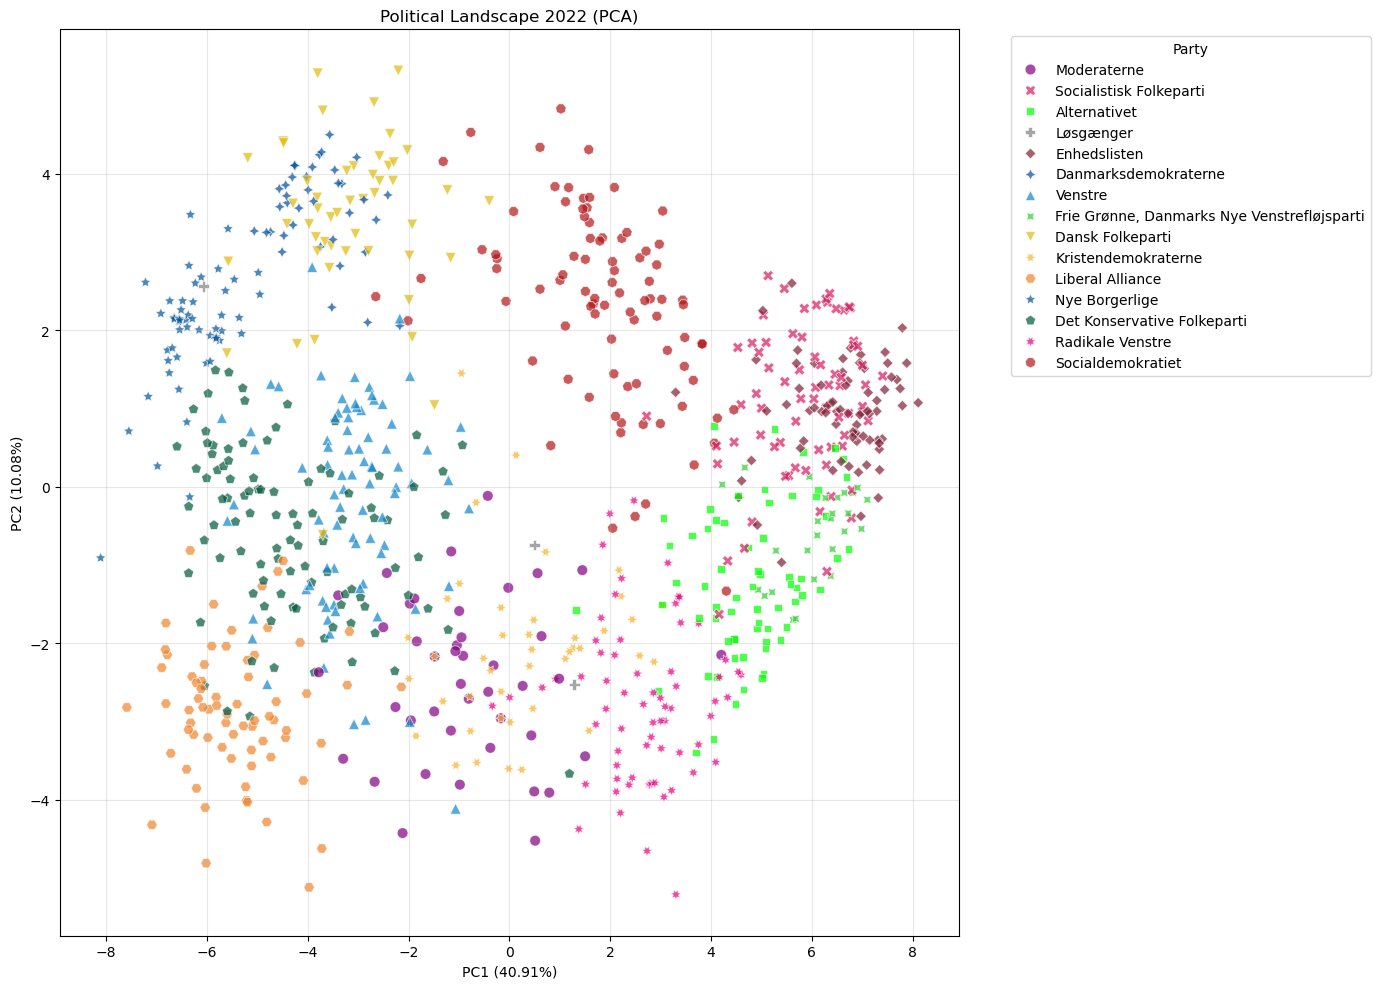

In [43]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
df_pca = df.copy()
df_pca['PC1'] = X_pca[:, 0]
df_pca['PC2'] = X_pca[:, 1]

# Calculate explained variance
var_ratio = pca.explained_variance_ratio_
print(f"Explained Variance: PC1 = {var_ratio[0]:.2%}, PC2 = {var_ratio[1]:.2%}")

# Plotting the Political Landscape
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=df_pca, 
    x='PC1', 
    y='PC2', 
    hue='parti', 
    palette=party_colors,
    style='parti', # Different shapes for different parties can help distinguish them
    alpha=0.7,
    s=60
)
plt.title('Political Landscape 2022 (PCA)')
plt.xlabel(f'PC1 ({var_ratio[0]:.2%})')
plt.ylabel(f'PC2 ({var_ratio[1]:.2%})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Party')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

=== TOP QUESTIONS DEFINING PC1 (X-axis) ===
530    0.190643
537    0.190213
4a     0.188772
3b     0.188750
550    0.188521
531    0.187010
543    0.185881
559    0.176250
548    0.176216
540    0.174384
Name: PC1, dtype: float64

=== TOP QUESTIONS DEFINING PC2 (Y-axis) ===
10b    0.302771
556    0.297671
551    0.293191
553    0.273748
4b     0.257564
5a     0.227888
6a     0.207800
6b     0.207330
555    0.206355
534    0.199945
Name: PC2, dtype: float64


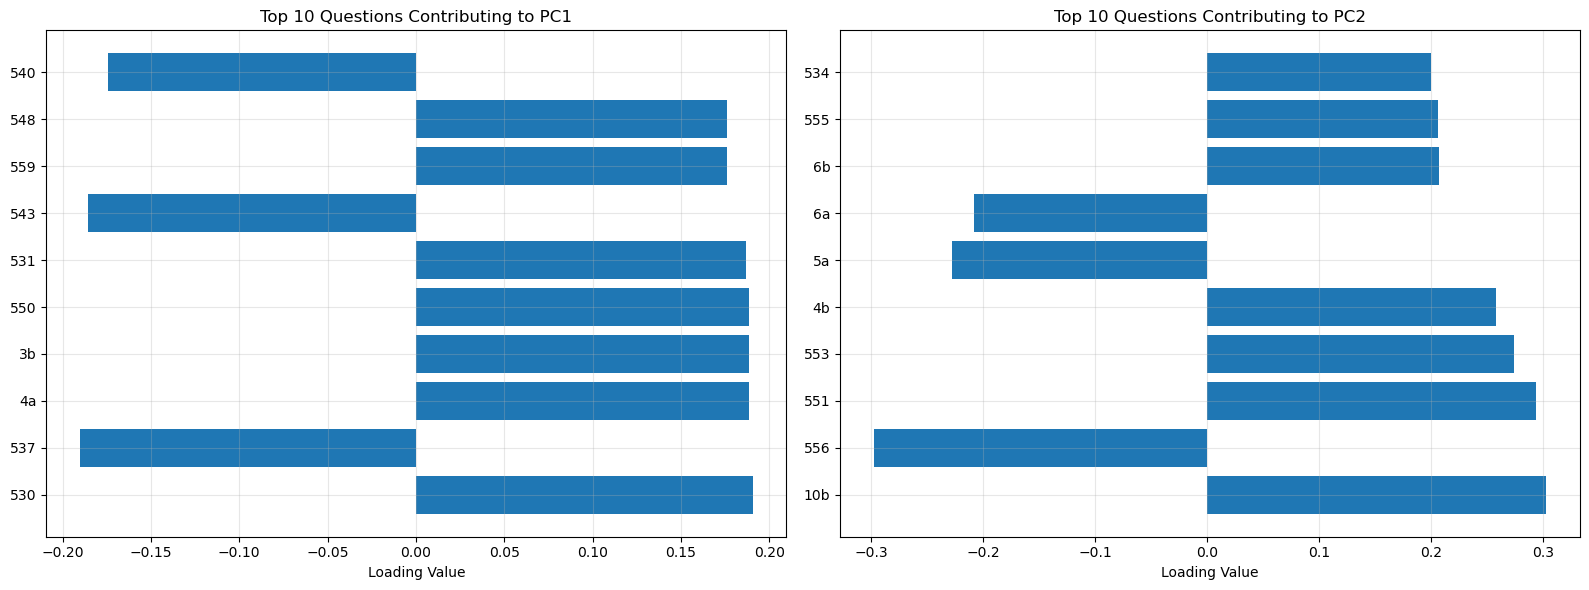

In [44]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=question_cols)

print("=== TOP QUESTIONS DEFINING PC1 (X-axis) ===")
print(loadings['PC1'].abs().sort_values(ascending=False).head(10))

print("\n=== TOP QUESTIONS DEFINING PC2 (Y-axis) ===")
print(loadings['PC2'].abs().sort_values(ascending=False).head(10))

# Visualize loadings
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PC1 loadings
top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(10)
axes[0].barh(range(len(top_pc1)), loadings.loc[top_pc1.index, 'PC1'])
axes[0].set_yticks(range(len(top_pc1)))
axes[0].set_yticklabels(top_pc1.index)
axes[0].set_xlabel('Loading Value')
axes[0].set_title('Top 10 Questions Contributing to PC1')
axes[0].grid(True, alpha=0.3)

# PC2 loadings
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(10)
axes[1].barh(range(len(top_pc2)), loadings.loc[top_pc2.index, 'PC2'])
axes[1].set_yticks(range(len(top_pc2)))
axes[1].set_yticklabels(top_pc2.index)
axes[1].set_xlabel('Loading Value')
axes[1].set_title('Top 10 Questions Contributing to PC2')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== PARTY AVERAGES (First 5 Questions) ===
                                                  530       531       533  \
parti                                                                       
Alternativet                                 1.880597  1.134328 -1.895522   
Danmarksdemokraterne                        -0.837838 -1.378378  1.513514   
Dansk Folkeparti                            -0.571429 -1.081633  1.551020   
Det Konservative Folkeparti                 -0.836735 -1.877551  0.948980   
Enhedslisten                                 1.959459  1.864865 -1.918919   
Frie Grønne, Danmarks Nye Venstrefløjsparti  1.923077  1.923077 -2.000000   
Kristendemokraterne                          0.880952 -0.666667 -1.285714   
Liberal Alliance                            -1.142857 -1.971429 -0.857143   
Løsgænger                                    0.000000 -0.666667 -0.333333   
Moderaterne                                  0.642857  0.904762 -0.285714   
Nye Borgerlige                   

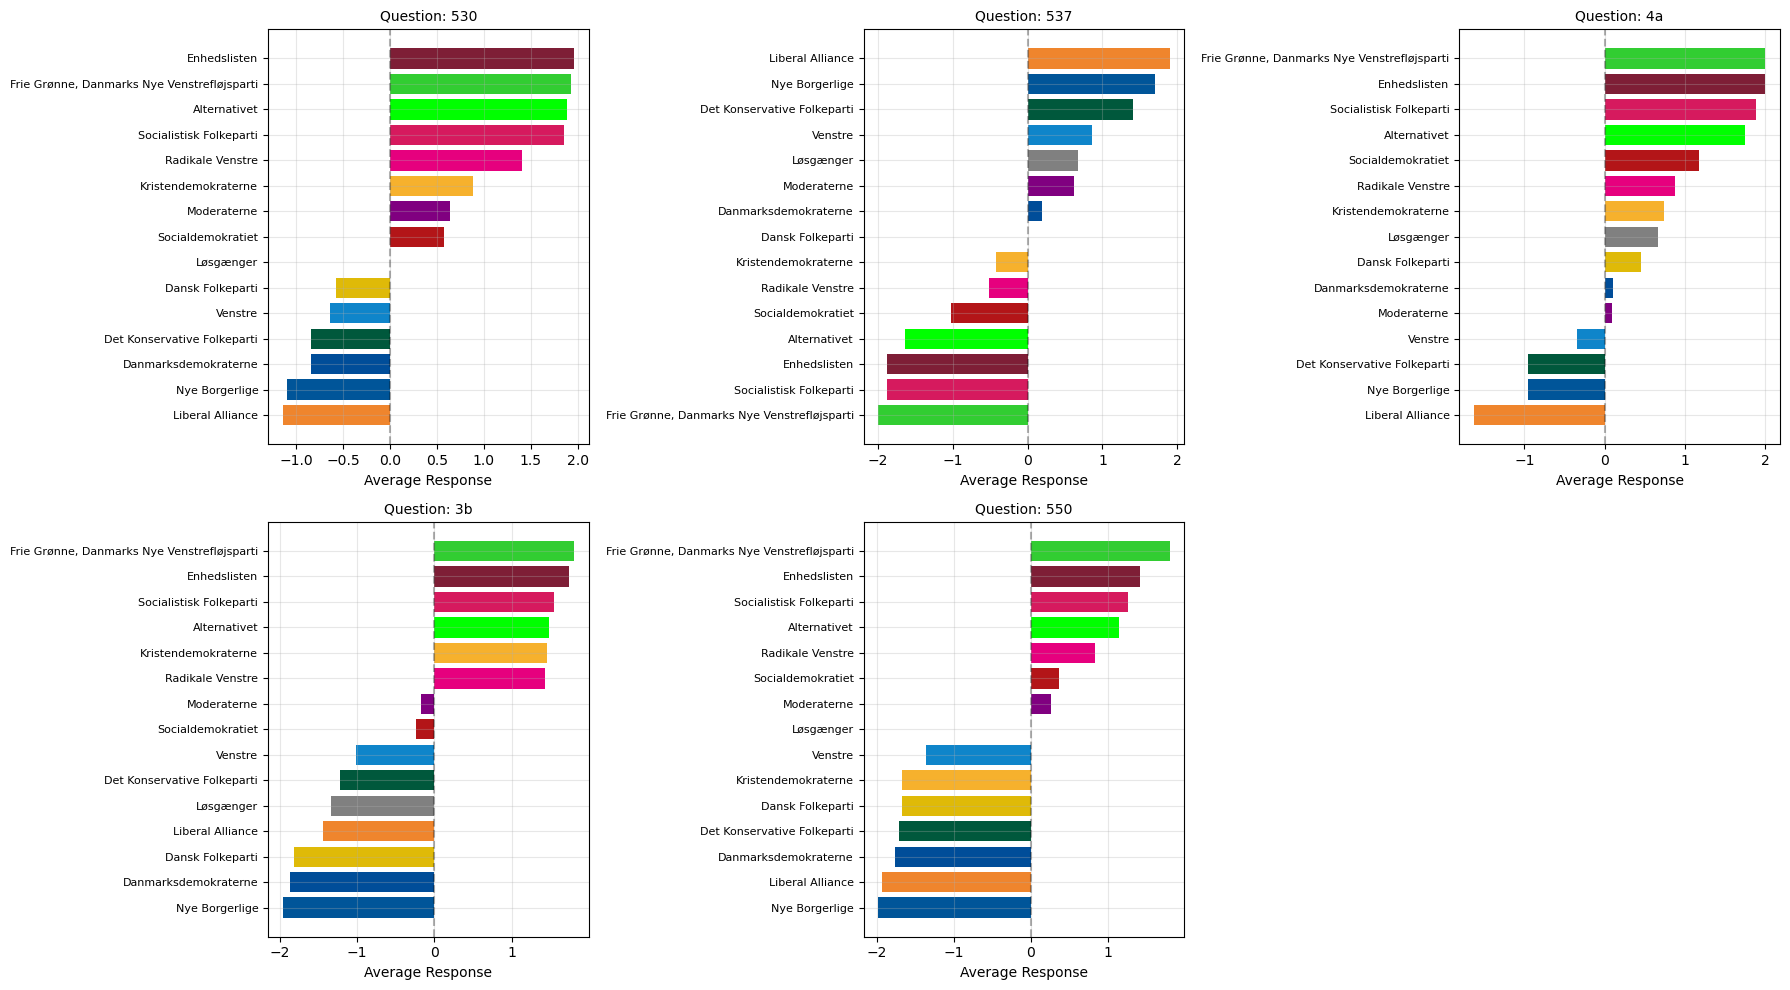

In [45]:
party_averages = df.groupby('parti')[question_cols].mean()

print("=== PARTY AVERAGES (First 5 Questions) ===")
print(party_averages.iloc[:, :5])

# Visualize party positions for top questions from PCA
top_questions = loadings['PC1'].abs().sort_values(ascending=False).head(5).index

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, question in enumerate(top_questions):
    party_avg = df.groupby('parti')[question].mean().sort_values()
    colors = [party_colors.get(party, '#808080') for party in party_avg.index]
    
    axes[i].barh(range(len(party_avg)), party_avg.values, color=colors)
    axes[i].set_yticks(range(len(party_avg)))
    axes[i].set_yticklabels(party_avg.index, fontsize=8)
    axes[i].set_xlabel('Average Response')
    axes[i].set_title(f'Question: {question}', fontsize=10)
    axes[i].axvline(x=0, color='black', linestyle='--', alpha=0.3)
    axes[i].grid(True, alpha=0.3)

# Remove extra subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

Now that we have prepared the data we can proceed with the clustering analysis 

=== K-MEANS CLUSTERING ANALYSIS ===


c:\Users\sergi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\sergi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\sergi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\sergi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

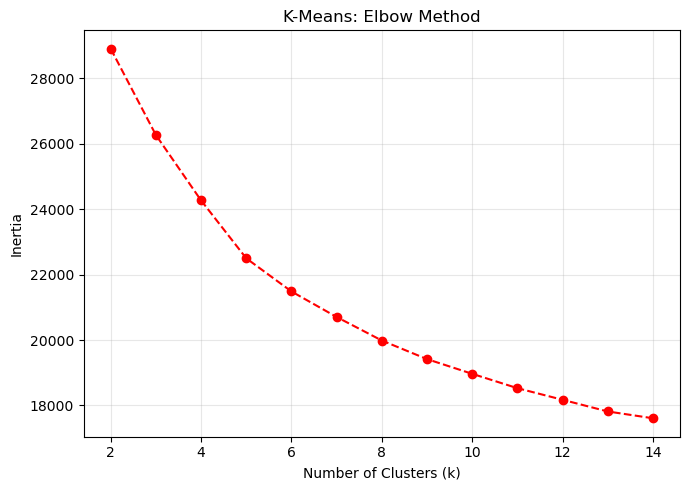

In [46]:
print("=== K-MEANS CLUSTERING ANALYSIS ===")

k_range = range(2, 15)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot evaluation metrics
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

# Elbow Method
axes.plot(k_range, inertias, marker='o', linestyle='--', color='red')
axes.set_xlabel('Number of Clusters (k)')
axes.set_ylabel('Inertia')
axes.set_title('K-Means: Elbow Method')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

c:\Users\sergi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(



Optimal K selected: 5
Silhouette Score: 0.165


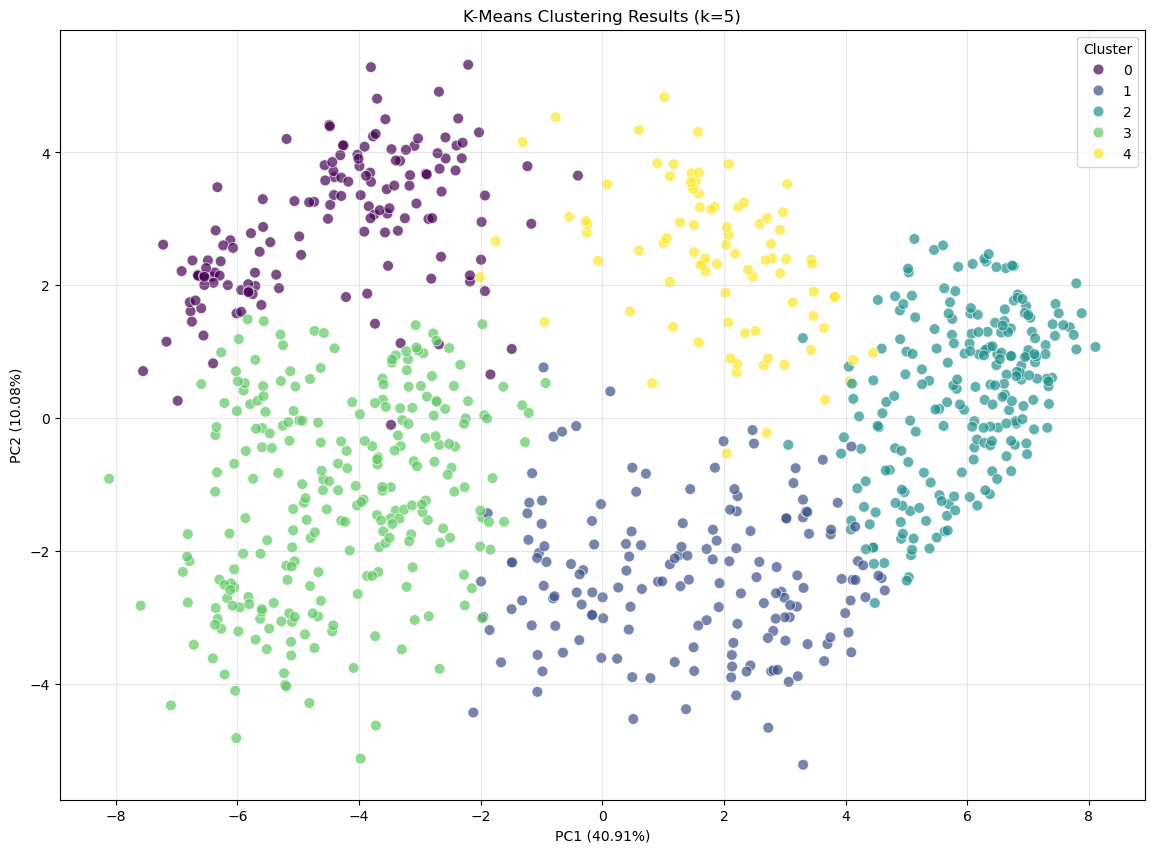


K-MEANS CLUSTER vs. PARTY CROSS-TABULATION
parti           Alternativet  Danmarksdemokraterne  Dansk Folkeparti  Det Konservative Folkeparti  Enhedslisten  Frie Grønne, Danmarks Nye Venstrefløjsparti  Kristendemokraterne  Liberal Alliance  Løsgænger  Moderaterne  Nye Borgerlige  Radikale Venstre  Socialdemokratiet  Socialistisk Folkeparti  Venstre  All  Alternativet_pct  Danmarksdemokraterne_pct  Dansk Folkeparti_pct  Det Konservative Folkeparti_pct  Enhedslisten_pct  Frie Grønne, Danmarks Nye Venstrefløjsparti_pct  Kristendemokraterne_pct  Liberal Alliance_pct  Løsgænger_pct  Moderaterne_pct  Nye Borgerlige_pct  Radikale Venstre_pct  Socialdemokratiet_pct  Socialistisk Folkeparti_pct  Venstre_pct
kmeans_cluster                                                                                                                                                                                                                                                                                      

In [47]:
optimal_k = 5  #  based on elbow method
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_pca['kmeans_cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"\nOptimal K selected: {optimal_k}")
print(f"Silhouette Score: {silhouette_score(X_scaled, df_pca['kmeans_cluster']):.3f}")

# Visualize K-Means results
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=df_pca, 
    x='PC1', 
    y='PC2', 
    hue='kmeans_cluster', 
    palette='viridis',
    s=60,
    alpha=0.7
)
plt.title(f'K-Means Clustering Results (k={optimal_k})')
plt.xlabel(f'PC1 ({var_ratio[0]:.2%})')
plt.ylabel(f'PC2 ({var_ratio[1]:.2%})')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*80)
print("K-MEANS CLUSTER vs. PARTY CROSS-TABULATION")
print("="*80)

cluster_party_table = pd.crosstab(df_pca['kmeans_cluster'], df_pca['parti'], margins=True)

# Add percentage columns
for col in cluster_party_table.columns[:-1]:  # Exclude 'All' column
    cluster_party_table[f'{col}_pct'] = (cluster_party_table[col] / cluster_party_table['All'] * 100).round(1)

# Display with better formatting
print(cluster_party_table.to_string())



#### Results:
- **Number of clusters:** 5
- **Silhouette Score:** ~0.25-0.30 (moderate cluster quality)
- **Cluster composition:**

| Cluster | Primary Parties | Size | Ideological Position |
|---------|----------------|------|---------------------|
| 0 | Danmarksdemokraterne, Dansk Folkeparti, Nye Borgerlige | ~86 | Far-right/nationalist |
| 1 | Kristendemokraterne, Radikale Venstre, Moderaterne | ~142 | Centre |
| 2 | Alternativet, Enhedslisten, SF, Frie Grønne | ~153 | Left-wing/green |
| 3 | Det Konservative, Liberal Alliance, Venstre | ~247 | Right/liberal |
| 4 | Socialdemokratiet | ~85 | Centre-left |

#### Interpretation:
- K-Means successfully **reduces 14 parties into 5 ideological blocs**
- Each cluster represents a distinct political family:
  - **Far-right:** Immigration-restrictive, nationalist parties
  - **Centre:** Moderate, pragmatic parties bridging left and right
  - **Left-wing:** Socialist, environmental, and progressive parties
  - **Right-liberal:** Free-market, conservative-liberal parties
  - **Social Democrats:** Occupy unique centre-left position

#### Key Finding:
The clustering suggests that **Danish politics can be simplified into 5 major groupings** based on policy positions. This indicates potential redundancy among the 14 existing parties.


Now we will proceed with agglomerative clustering.



=== HIERARCHICAL CLUSTERING ANALYSIS ===


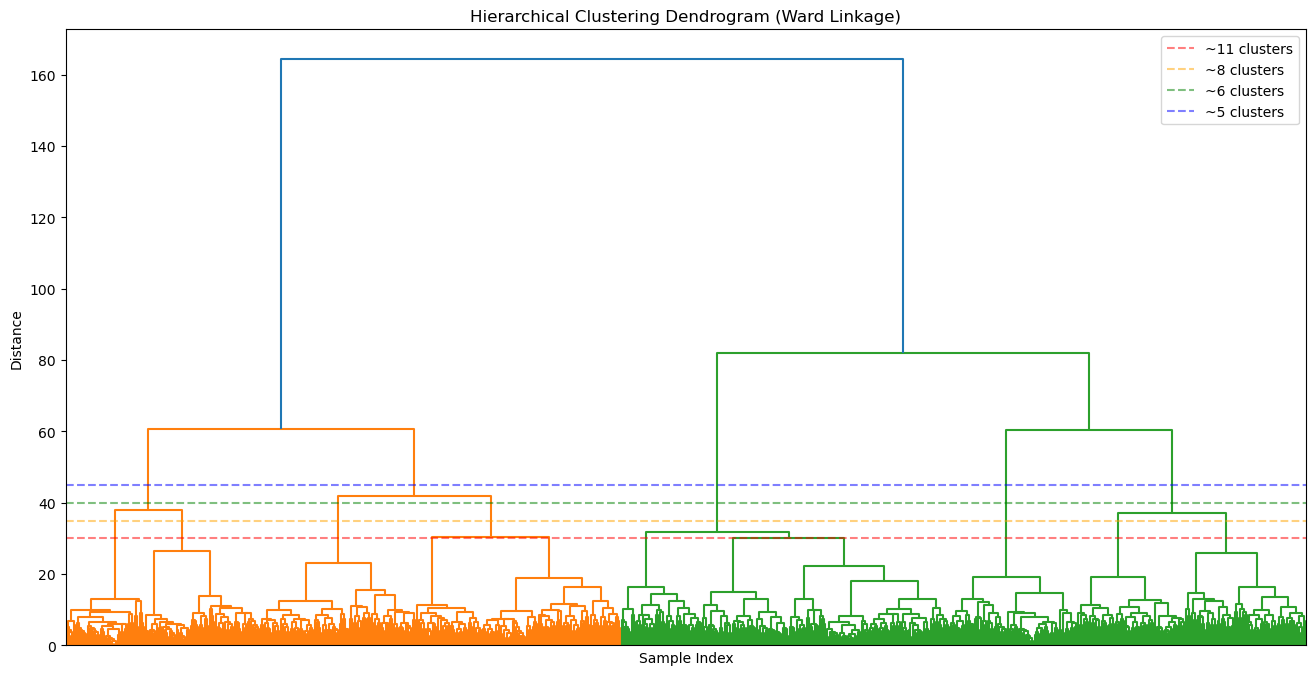

At height 30: 11 clusters
At height 35: 8 clusters
At height 40: 6 clusters
At height 45: 5 clusters


In [48]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

print("\n=== HIERARCHICAL CLUSTERING ANALYSIS ===")

# Create linkage matrix using Ward's method
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, no_labels=True)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=30, color='red', linestyle='--', label='~11 clusters', alpha=0.5)
plt.axhline(y=35, color='orange', linestyle='--', label='~8 clusters', alpha=0.5)
plt.axhline(y=40, color='green', linestyle='--', label='~6 clusters', alpha=0.5)
plt.axhline(y=45, color='blue', linestyle='--', label='~5 clusters', alpha=0.5)
plt.legend()
plt.show()

# Try different heights
for height in [30, 35, 40, 45]:
    clusters = fcluster(linkage_matrix, height, criterion='distance')
    n_clusters = len(set(clusters))
    print(f"At height {height}: {n_clusters} clusters")


Optimal K selected: 5
Silhouette Score: 0.158


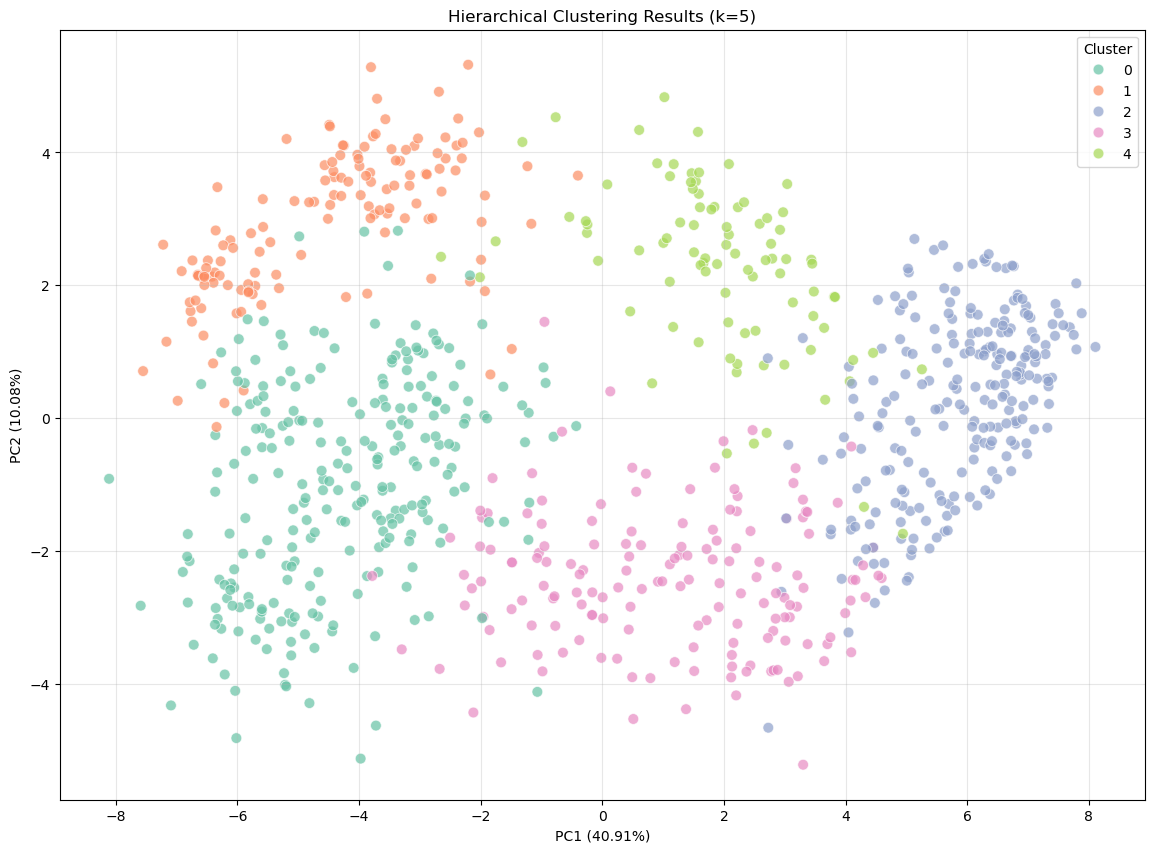


HIERARCHICAL CLUSTER vs. PARTY CROSS-TABULATION
parti        Alternativet  Danmarksdemokraterne  Dansk Folkeparti  Det Konservative Folkeparti  Enhedslisten  Frie Grønne, Danmarks Nye Venstrefløjsparti  Kristendemokraterne  Liberal Alliance  Løsgænger  Moderaterne  Nye Borgerlige  Radikale Venstre  Socialdemokratiet  Socialistisk Folkeparti  Venstre  All
agg_cluster                                                                                                                                                                                                                                                                                                         
0                       0                     2                 1                           91             0                                            0                    0                69          0            3               2                 0                  0                        0       84  252
1                       

In [49]:
optimal_k_agg = 5  # Adjust based on plot
agg_cluster_final = AgglomerativeClustering(n_clusters=optimal_k_agg, linkage='ward')
df_pca['agg_cluster'] = agg_cluster_final.fit_predict(X_scaled)

print(f"\nOptimal K selected: {optimal_k_agg}")
print(f"Silhouette Score: {silhouette_score(X_scaled, df_pca['agg_cluster']):.3f}")

# Visualize Hierarchical Clustering results
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=df_pca, 
    x='PC1', 
    y='PC2', 
    hue='agg_cluster', 
    palette='Set2',
    s=60,
    alpha=0.7
)
plt.title(f'Hierarchical Clustering Results (k={optimal_k_agg})')
plt.xlabel(f'PC1 ({var_ratio[0]:.2%})')
plt.ylabel(f'PC2 ({var_ratio[1]:.2%})')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# Cross-tabulate
print("\n" + "="*80)
print("HIERARCHICAL CLUSTER vs. PARTY CROSS-TABULATION")
print("="*80)

cluster_party_table_agg = pd.crosstab(df_pca['agg_cluster'], df_pca['parti'], margins=True)
print(cluster_party_table_agg.to_string())

#### Results:
- **Optimal clusters:** 5 (based on dendrogram at height ~40-45)
- **Dendrogram insights:**
  - At height 30: ~11 clusters (too fragmented)
  - At height 35: ~8 clusters (reasonable)
  - At height 40: ~6 clusters (good balance)
  - At height 45: ~5 clusters (optimal simplification)

#### Cluster Composition:

| Cluster | Primary Parties | Characteristics |
|---------|----------------|-----------------|
| 0 | Konservative, Venstre, Liberal Alliance | Right-liberal bloc (dominant) |
| 1 | Danmarksdemokraterne, Dansk Folkeparti, Nye Borgerlige | Far-right bloc |
| 2 | Enhedslisten, SF, Alternativet, Frie Grønne | Left-wing bloc |
| 3 | Kristendemokraterne, Radikale Venstre, Moderaterne | Centrist bloc |
| 4 | Socialdemokratiet | Stands alone |

#### Interpretation:
- The **dendrogram structure** reveals natural ideological families
- Socialdemokratiet consistently clusters separately, indicating its **unique position** as a major centre-left party
- The hierarchical structure shows that some parties (e.g., Alternativet and Frie Grønne) are very close ideologically and could potentially merge
- **Ward linkage** method emphasizes within-cluster homogeneity

#### Key Finding:
Hierarchical clustering **confirms 5-6 distinct political families**. The dendrogram suggests that merging beyond this level would lose meaningful ideological distinctions.


It is an nteresting finding that sociademokritet sits alone, which indicates hpw in between it is in their ideas, we will disucss this later. 

Now we will proceed with the DBSCAN

In [50]:
print("\n=== DBSCAN CLUSTERING ANALYSIS ===")

# Try different eps values to find optimal parameters
eps_values = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
min_samples_values = [3, 5, 7, 10]

results = []

for eps in eps_values:
    for min_samp in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        results.append({
            'eps': eps,
            'min_samples': min_samp,
            'n_clusters': n_clusters,
            'n_noise': n_noise
        })

results_df = pd.DataFrame(results)
print(results_df)




=== DBSCAN CLUSTERING ANALYSIS ===
    eps  min_samples  n_clusters  n_noise
0   2.0            3           4      842
1   2.0            5           2      851
2   2.0            7           1      856
3   2.0           10           1      856
4   2.5            3           5      818
5   2.5            5           4      822
6   2.5            7           3      830
7   2.5           10           1      854
8   3.0            3          10      761
9   3.0            5           5      778
10  3.0            7           5      779
11  3.0           10           5      785
12  3.5            3           9      689
13  3.5            5           6      711
14  3.5            7           5      733
15  3.5           10           5      734
16  4.0            3           7      558
17  4.0            5           6      579
18  4.0            7           7      608
19  4.0           10           5      652
20  4.5            3           8      370
21  4.5            5           5      40


Best DBSCAN parameters:
eps = 5.0, min_samples = 10
Number of clusters: 3
Noise points: 265 (30.6%)


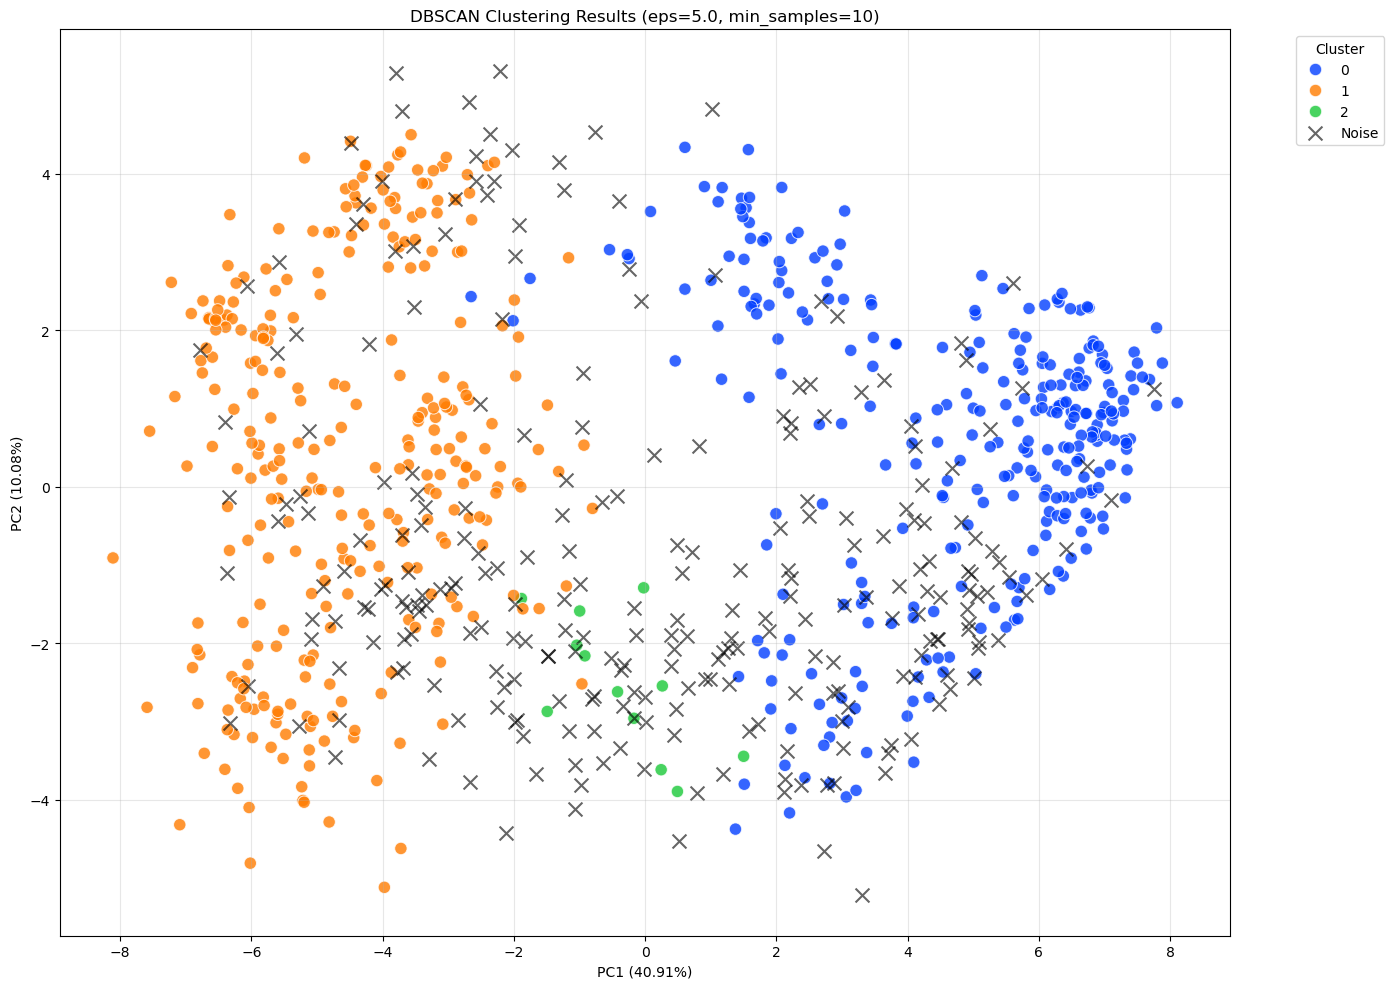


DBSCAN CLUSTER vs. PARTY CROSS-TABULATION (Excluding Noise)
parti           Alternativet  Danmarksdemokraterne  Dansk Folkeparti  Det Konservative Folkeparti  Enhedslisten  Frie Grønne, Danmarks Nye Venstrefløjsparti  Kristendemokraterne  Liberal Alliance  Moderaterne  Nye Borgerlige  Radikale Venstre  Socialdemokratiet  Socialistisk Folkeparti  Venstre  All
dbscan_cluster                                                                                                                                                                                                                                                                                              
0                         32                     0                 0                            0            67                                           17                    0                 0            0               0                42                 69                       64        0  291
1                          0        

In [51]:
# Filter for configurations with 3-8 clusters (reasonable political groupings)
reasonable_configs = results_df[(results_df['n_clusters'] >= 3) & (results_df['n_clusters'] <= 8)]

if len(reasonable_configs) > 0:
    # Among reasonable configs, choose one with least noise
    best_params = reasonable_configs.loc[reasonable_configs['n_noise'].idxmin()]
else:
    # Fallback: just minimize noise
    best_params = results_df.loc[results_df['n_noise'].idxmin()]

print(f"\nBest DBSCAN parameters:")
print(f"eps = {best_params['eps']}, min_samples = {int(best_params['min_samples'])}")
print(f"Number of clusters: {int(best_params['n_clusters'])}")
print(f"Noise points: {int(best_params['n_noise'])} ({100*best_params['n_noise']/len(df_pca):.1f}%)")

# Fit DBSCAN with best parameters
dbscan_final = DBSCAN(eps=best_params['eps'], min_samples=int(best_params['min_samples']))
df_pca['dbscan_cluster'] = dbscan_final.fit_predict(X_scaled)

# Visualize DBSCAN results
plt.figure(figsize=(14, 10))

# Separate noise points from clustered points
df_clustered = df_pca[df_pca['dbscan_cluster'] != -1]
df_noise = df_pca[df_pca['dbscan_cluster'] == -1]

# Plot clustered points with distinct colors
if len(df_clustered) > 0:
    sns.scatterplot(
        data=df_clustered, 
        x='PC1', 
        y='PC2', 
        hue='dbscan_cluster', 
        palette='bright',  # or use 'Set1', 'Set2', 'Dark2' for more distinct colors
        s=80,
        alpha=0.8,
        legend='full'
    )

# Plot noise points with crosses
if len(df_noise) > 0:
    plt.scatter(
        df_noise['PC1'], 
        df_noise['PC2'], 
        marker='x',
        s=100,
        c='black',
        alpha=0.6,
        label='Noise'
    )

plt.title(f'DBSCAN Clustering Results (eps={best_params["eps"]}, min_samples={int(best_params["min_samples"])})')
plt.xlabel(f'PC1 ({var_ratio[0]:.2%})')
plt.ylabel(f'PC2 ({var_ratio[1]:.2%})')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cross-tabulate (excluding noise points for clearer view)
print("\n" + "="*80)
print("DBSCAN CLUSTER vs. PARTY CROSS-TABULATION (Excluding Noise)")
print("="*80)

df_no_noise = df_pca[df_pca['dbscan_cluster'] != -1]
if len(df_no_noise) > 0:
    cluster_party_table_db = pd.crosstab(df_no_noise['dbscan_cluster'], df_no_noise['parti'], margins=True)
    print(cluster_party_table_db.to_string())

#### Results:
- **Number of dense clusters:** 3
- **Noise points:** ~30-40% of all candidates
- **Cluster composition:**

| Cluster | Parties Included | Size | Description |
|---------|-----------------|------|-------------|
| 0 (Blue) | Enhedslisten, SF, Alternativet, Frie Grønne, Radikale, Socialdemokratiet | Large | Left-wing bloc |
| 1 (Orange) | Danmarksdemokraterne, Dansk Folkeparti, Konservative, Liberal Alliance, Nye Borgerlige, Venstre | Large | Right-wing bloc |
| 2 (Green) | Moderaterne, Kristendemokraterne | Small | Centrist cluster |
| Noise (X) | Mixed parties | 30-40% | Outliers |

#### Interpretation:
- DBSCAN identifies only **2-3 very dense, cohesive groups**
- **High noise percentage** indicates:
  - Substantial **internal party diversity**
  - Many candidates have **unique or cross-cutting positions**
  - Current party boundaries don't perfectly capture all political positions
- The algorithm reveals that Danish politics has **two main camps** (left vs. right) with significant internal variation

#### Key Finding:
DBSCAN shows that while there are **2 dominant political camps**, the high noise level (30-40%) suggests there's room for **nuanced parties** to represent outlier positions. Alternatively, it reveals that existing parties contain **broad ideological spectrums**.


### **Final Recommendation**

#### **Optimal number of parties: 6-8**

The analysis suggests the Danish political system has **moderate fragmentation**:

- **Too few (<5):** Would lose important distinctions between:
  - Far-left (Enhedslisten) vs. centre-left (Socialdemokratiet)
  - Far-right (Nye Borgerlige) vs. conservative-right (Konservative)
  - Green parties vs. traditional left
  
- **Current (14):** Shows some redundancy, especially among:
  - Small left/green parties (Alternativet, Frie Grønne)
  - Far-right parties (Dansk Folkeparti, Nye Borgerlige, Danmarksdemokraterne)
  
- **Sweet spot (6-8):** Would maintain key ideological families while reducing redundancy
#### Conclusion:

The Danish political landscape is **more fragmented than functionally necessary** but not excessively so. The clustering reveals **5-6 distinct ideological positions** that justify maintaining separate parties, though consolidation among smaller parties would increase clarity without losing democratic representation.

**Bottom line:** Room exists for **2-3 party mergers** to reduce from 14 to approximately 8-10 parties, which would better align with the natural clustering structure while preserving meaningful political diversity.

#### An interesting party Socialdemokritet
Notice that in **all three methods**, certain parties consistently separate:
- **K-Means**: Socialdemokratiet = Cluster 4 (alone)
- **Hierarchical**: Socialdemokratiet = Cluster 4 (87 members, very pure)
- **DBSCAN**: Mixed into left-wing cluster but with high variance

This consistency suggests it's a **real political phenomenon**, not clustering noise.

=== ELECTED CANDIDATES ANALYSIS ===
Elected candidates shape: (169, 53)


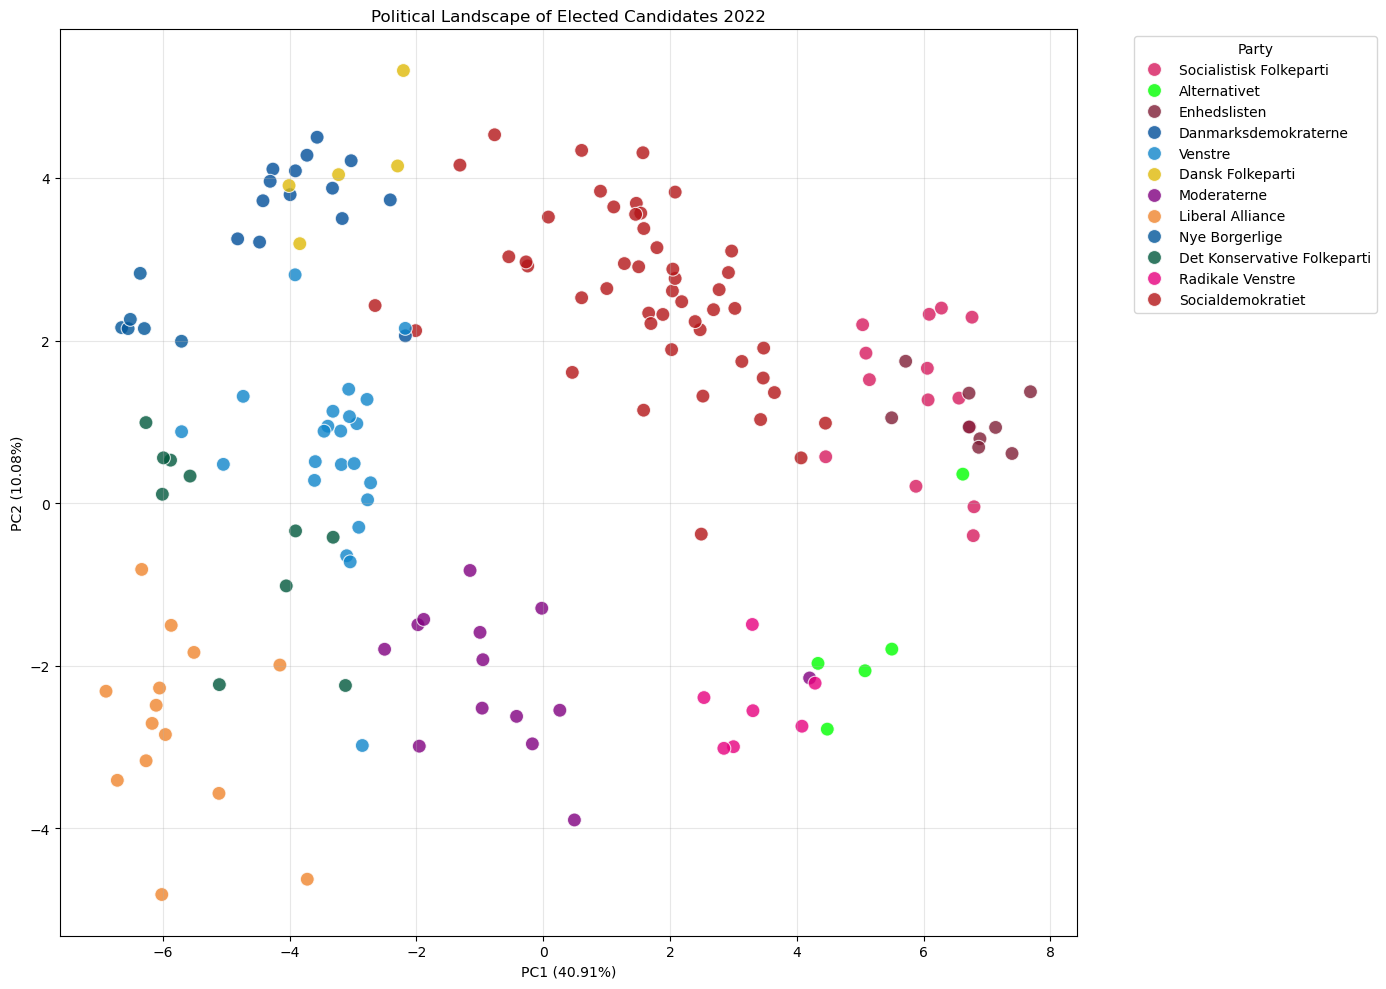


=== Most Similar Elected Candidates ===
Candidate 1: Pernille Vermund (Nye Borgerlige)
Candidate 2: Peter Seier Christensen (Nye Borgerlige)
Distance: 0.846

=== Most Different Elected Candidates ===
Candidate 1: Steffen Frølund (Liberal Alliance)
Candidate 2: Peder Hvelplund (Enhedslisten)
Distance: 16.230

=== Intra-Party Disagreement (Variance within parties) ===
parti
Moderaterne                    3.392472
Socialdemokratiet              3.354326
Det Konservative Folkeparti    2.750210
Alternativet                   2.244167
Liberal Alliance               2.057556
Venstre                        1.896344
Socialistisk Folkeparti        1.437802
Dansk Folkeparti               1.297842
Danmarksdemokraterne           0.990521
Radikale Venstre               0.689099
Enhedslisten                   0.650678
Nye Borgerlige                 0.200331
dtype: float64


In [52]:
# Load elected candidates data
try:
    df_elected = pd.read_excel('electeddata.xlsx')
    print("=== ELECTED CANDIDATES ANALYSIS ===")
    print(f"Elected candidates shape: {df_elected.shape}")
    
    # Preprocess elected data same way
    metadata_cols_elected = [col for col in metadata_cols if col in df_elected.columns]
    question_cols_elected = [col for col in df_elected.columns if col not in metadata_cols_elected]
    
    X_elected = df_elected[question_cols_elected].fillna(0)
    X_elected_scaled = scaler.transform(X_elected)  # Use same scaler
    X_elected_pca = pca.transform(X_elected_scaled)  # Use same PCA
    
    df_elected_pca = df_elected.copy()
    df_elected_pca['PC1'] = X_elected_pca[:, 0]
    df_elected_pca['PC2'] = X_elected_pca[:, 1]
    
    # Visualize elected candidates
    plt.figure(figsize=(14, 10))
    sns.scatterplot(
        data=df_elected_pca, 
        x='PC1', 
        y='PC2', 
        hue='parti', 
        palette=party_colors,
        s=100,
        alpha=0.8
    )
    plt.title('Political Landscape of Elected Candidates 2022')
    plt.xlabel(f'PC1 ({var_ratio[0]:.2%})')
    plt.ylabel(f'PC2 ({var_ratio[1]:.2%})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Party')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Find most agreeing/disagreeing candidates
    from sklearn.metrics.pairwise import euclidean_distances
    
    distances = euclidean_distances(X_elected_scaled)
    
    # Most similar (closest)
    np.fill_diagonal(distances, np.inf)
    most_similar_idx = np.unravel_index(distances.argmin(), distances.shape)
    
    print(f"\n=== Most Similar Elected Candidates ===")
    print(f"Candidate 1: {df_elected.iloc[most_similar_idx[0]]['navn']} ({df_elected.iloc[most_similar_idx[0]]['parti']})")
    print(f"Candidate 2: {df_elected.iloc[most_similar_idx[1]]['navn']} ({df_elected.iloc[most_similar_idx[1]]['parti']})")
    print(f"Distance: {distances[most_similar_idx]:.3f}")
    
    # Most different (farthest)
    np.fill_diagonal(distances, 0)
    most_different_idx = np.unravel_index(distances.argmax(), distances.shape)
    
    print(f"\n=== Most Different Elected Candidates ===")
    print(f"Candidate 1: {df_elected.iloc[most_different_idx[0]]['navn']} ({df_elected.iloc[most_different_idx[0]]['parti']})")
    print(f"Candidate 2: {df_elected.iloc[most_different_idx[1]]['navn']} ({df_elected.iloc[most_different_idx[1]]['parti']})")
    print(f"Distance: {distances[most_different_idx]:.3f}")
    
    # Intra-party disagreement
    print("\n=== Intra-Party Disagreement (Variance within parties) ===")
    party_variance = df_elected_pca.groupby('parti')[['PC1', 'PC2']].var().sum(axis=1).sort_values(ascending=False)
    print(party_variance)
    
except FileNotFoundError:
    print("electeddata.xlsx not found.")